### ERDDAP 2018 Oculus Glider QuickLooks and Analysis

#### Puget Sound Spring Test for SG403

Glider Data is subsetted into various components to be hosted on ERDDAP due to mulitple time dimensions


In [42]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import datetime

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

In [43]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='sg403'))

The dataset is spread across multiple datasets in the erddap server so we need to join them all together

In [44]:
sg403 = df['Dataset ID'].values
print(sg403)

['sg403_PS_spring18' 'sg403_PS_spring18_aanderaa'
 'sg403_PS_spring18_wetlabs']


In [45]:
variables = [e.get_var_by_attr(dataset_id=sg, standard_name=lambda v: v is not None) for sg in sg403]
print(variables)
variables = [e.get_var_by_attr(dataset_id=sg, standard_name=lambda v: v is None) for sg in sg403]
print(variables)

[['time', 'density', 'ctd_depth', 'latitude', 'longitude', 'salinity', 'temperature', 'eng_depth'], ['aa4330_temp', 'time', 'aanderaa4330_dissolved_oxygen', 'aa4330_airsat'], ['time']]
[['profileid', 'NC_GLOBAL', 'pressure'], ['profileid_aand', 'NC_GLOBAL'], ['wlbb2fl_sig700nm_adjusted', 'wlbb2fl_temp', 'wlbb2fl_sig470nm_adjusted', 'wlbb2fl_sig695nm_adjusted', 'NC_GLOBAL', 'profileid_wetlabs']]


In [57]:
constraints = {
    'time>=': '2018-01-01T00:00:00Z',
    'time<=': str(datetime.datetime.today()),
}

variables = {'sg403_PS_spring18':['latitude', 
             'ctd_depth', 
             'longitude', 
             'salinity',
             'density', 
             'time', 
             'temperature'],
             'sg403_PS_spring18_wetlabs':['time',
             'wlbb2fl_sig695nm_adjusted',
             'wlbb2fl_sig470nm_adjusted', 
             'wlbb2fl_sig700nm_adjusted', 
             'wlbb2fl_temp',
             'profileid_wetlabs'],
             'sg403_PS_spring18_aanderaa':['time',
             'aanderaa4330_dissolved_oxygen',
             'aa4330_airsat',
             'aa4330_temp']}



In [58]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='nc'
          )
d.dataset_id='sg403_PS_spring18'
d.variables=variables['sg403_PS_spring18']
d.constraints=constraints

download_url = d.get_download_url()

In [59]:
from requests.exceptions import HTTPError

dfs = {}
for index,row in df.iterrows():
    if row['Dataset ID'] in sg403:
        print(row['Dataset ID'])
        try:
            e = ERDDAP(server=server_url,
                protocol='tabledap',
                response='csv',
            )
            e.dataset_id=row['Dataset ID']
            e.constraints=constraints
            e.variables=variables[row['Dataset ID']]
        except HTTPError:
            print('Failed to generate url {}'.format(row['Dataset ID']))
            continue
        dfs.update({row['Dataset ID']: e.to_pandas(
                                index_col='time',
                                parse_dates=True,
                                skiprows=(1,)  # units information can be dropped.
                                )})
    

sg403_PS_spring18
sg403_PS_spring18_aanderaa
sg403_PS_spring18_wetlabs


In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

def plot_params(df, var=None,varstr='',cmap=cmocean.cm.thermal,vmin=None,vmax=None):
    fig, ax = plt.subplots(figsize=(17, 2))
    if vmin:
        cs = ax.scatter(df.index, df['ctd_depth'], s=15, c=df[var], marker='o', edgecolor='none',cmap=cmap,vmin=vmin,vmax=vmax)
    else:
        cs = ax.scatter(df.index, df['ctd_depth'], s=15, c=df[var], marker='o', edgecolor='none',cmap=cmap)
        
    ax.invert_yaxis()
    ax.set_xlim(df.index[0], df.index[-1])
    xfmt = mdates.DateFormatter('%d-%b\n%H:%M')
    ax.xaxis.set_major_formatter(xfmt)

    cbar = fig.colorbar(cs, orientation='vertical', extend='both')
    cbar.ax.set_ylabel(varstr)
    ax.set_ylabel('Depth (m)')


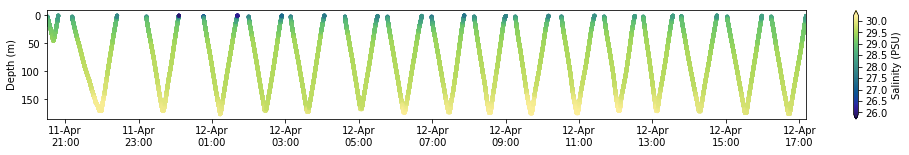

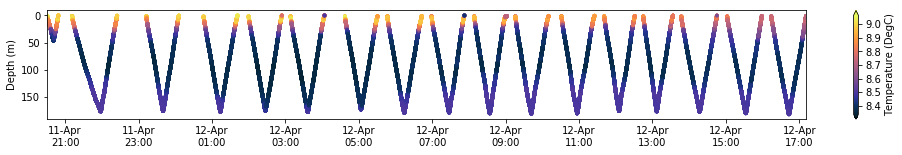

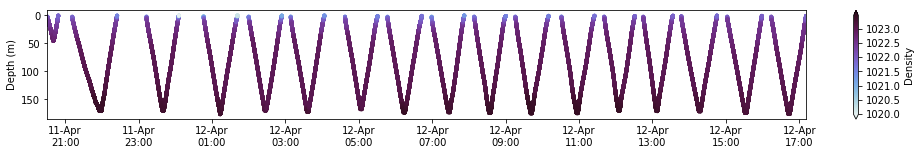

In [85]:
plot_params(dfs['sg403_PS_spring18'], 'salinity','Salinity (PSU)',cmocean.cm.haline)

plot_params(dfs['sg403_PS_spring18'], 'temperature','Temperature (DegC)')

plot_params(dfs['sg403_PS_spring18'], 'density','Density',cmocean.cm.dense)

In [86]:
### depth needs to be downsampled to the other database freqencyies to plot chlor/oxy

dfwet = dfs['sg403_PS_spring18_wetlabs'].join(dfs['sg403_PS_spring18'])
dfaan = dfs['sg403_PS_spring18_aanderaa'].join(dfs['sg403_PS_spring18'])

#quick QC
dfaan.aa4330_airsat[dfaan.aa4330_airsat < 0] =np.nan


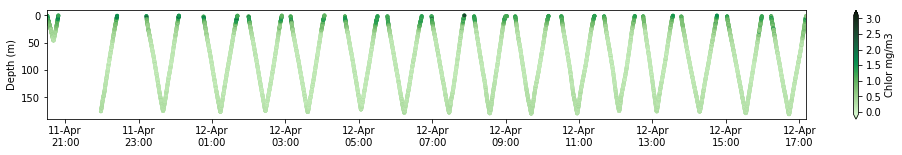

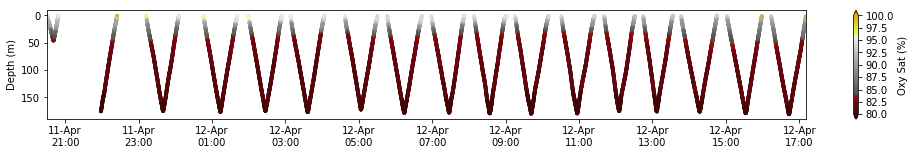

In [87]:
plot_params(dfwet, 'wlbb2fl_sig695nm_adjusted','Chlor mg/m3',cmocean.cm.algae)

plot_params(dfaan, 'aa4330_airsat','Oxy Sat (%)',cmocean.cm.oxy,vmin=80,vmax=100)